In [257]:
import numpy as np
from numpy.linalg import inv, cholesky, LinAlgError
from joblib import Parallel, delayed
import seaborn as sns
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt

def omega_bootstrap(A, replicates=1000, samples_per_replicate=10000,
                    use_chol_decomp=False, n_jobs=-1, seed=None):
    """
    Estimates Omega(A): the proportion of feasible vectors within the unit sphere.
    Uses Monte Carlo sampling from N(0, Σ) and evaluates how many fall within the positive orthant.
    
    Parameters:
        A : np.ndarray
            Interaction matrix (SxS)
        replicates : int
            Number of independent estimates
        samples_per_replicate : int
            Number of samples per estimate
        use_chol_decomp : bool
            If True, uses Cholesky decomposition to invert AᵀA
        n_jobs : int
            Number of parallel processes to use
        seed : int or None
            Random seed for reproducibility
    
    Returns:
        np.ndarray
            Omega estimates (length = replicates)
    """
    A = np.array(A)
    S = A.shape[0]

    if A.shape[1] != S:
        raise ValueError("Matrix A should be square (SxS)")

    # Normalizar columnas de A para que estén en la esfera unitaria
    column_norms = np.linalg.norm(A, axis=0)
    if np.any(column_norms == 0):
        raise ValueError("Some columns are 0.")
    A = A / column_norms
    
    try:
        AtA = A.T @ A
        if use_chol_decomp:
            L = cholesky(AtA)
            Sigma = inv(L.T) @ inv(L)
        else:
            Sigma = inv(AtA)
    except LinAlgError:
        raise ValueError("Not inverse of AᵀA. Coul be non defined positive.")

    if seed is not None:
        np.random.seed(seed)

    # Factor de descomposición para muestreo
    L = cholesky(Sigma)

    def estimate():
        Z = np.random.randn(samples_per_replicate, S)  # muestras estándar
        X = Z @ L.T  # transformación para obtener covarianza Σ
        is_positive = (X > 0).all(axis=1)
        return np.mean(is_positive)

    results = Parallel(n_jobs=n_jobs)(delayed(estimate)() for _ in range(replicates))

    return np.array(results)


In [258]:
def calculateC(name):
    A = pd.read_csv('complexity72h-2025-main/data/'+name+'/matrix_A.csv').to_numpy()[:,1:].astype(np.float64)
    B = pd.read_csv('complexity72h-2025-main/data/'+name+'/matrix_B.csv').to_numpy()[:,1:].astype(np.float64)
    P = pd.read_csv('complexity72h-2025-main/data/'+name+'/env.csv')
    P = P.drop(columns=['Unnamed: 0'], errors='ignore').to_numpy()

    C = np.zeros((A.shape[0], A.shape[1], len(P)))
    for i,p in enumerate(P):
        C[:,:,i] = A + B*p[0]
    #C = A[:,:,np.newaxis] + B[:,:,np.newaxis] * P.T

    return -C
    
def calculateC_sd(name):
    A = pd.read_csv('complexity72h-2025-main/data/'+name+'/matrix_A.csv').to_numpy()[:,1:].astype(np.float64)
    Asd = pd.read_csv('complexity72h-2025-main/data/'+name+'/matrix_A_sd.csv').to_numpy()[:,1:].astype(np.float64)
    
    B = pd.read_csv('complexity72h-2025-main/data/'+name+'/matrix_B.csv').to_numpy()[:,1:].astype(np.float64)
    Bsd = pd.read_csv('complexity72h-2025-main/data/'+name+'/matrix_B_sd.csv').to_numpy()[:,1:].astype(np.float64)
    
    P = pd.read_csv('complexity72h-2025-main/data/'+name+'/env.csv')
    P = P.drop(columns=['Unnamed: 0'], errors='ignore').to_numpy()


    C = np.zeros((A.shape[0], A.shape[1], len(P)))
    for i,p in enumerate(P):
        C[:,:,i] = np.random.normal(loc=A, scale=Asd) + np.random.normal(loc=B, scale=Bsd)*p[0]

    """
    plt.scatter((np.random.normal(loc=A, scale=Asd)).flatten(), np.random.normal(loc=A, scale=0).flatten())
    plt.xlabel('Sd')
    plt.ylabel('0')
    plt.plot([np.min(A), np.max(A)],[np.min(A),np.max(A)],'--',color='gray')
    plt.show()
    """
    
    #C = np.random.normal(loc=A, scale=0)[:,:,np.newaxis] + np.random.normal(loc=B, scale=0)[:,:,np.newaxis] * P.T

    return -C

def giveP(name):
    P = pd.read_csv('complexity72h-2025-main/data/'+name+'/env.csv')
    P = P.drop(columns=['Unnamed: 0'], errors='ignore').to_numpy()
    return P.transpose()[0]

def calculateOmegas(C):
    temporal = C.shape[-1]
    Omegas = np.zeros((temporal))
    for t in range(temporal):
        Omegas[t] = np.mean(omega_bootstrap(C[:,:,t], replicates=1000, samples_per_replicate=10000))
    return Omegas 

def plotOmegas(name,Omegas):
    plt.plot(Omegas)
    plt.scatter(range(len(Omegas)), Omegas, edgecolors='black',s=50)
    plt.title(name)
    plt.xlabel('Years')
    plt.ylabel('Feasibility Domain')
    plt.show()

In [259]:
OmegaBEEFUN = calculateOmegas(calculateC('BEEFUN'))
OmegaS_BEEFUN = []
for i in range(100):
    OmegaS_BEEFUN.append(calculateOmegas(calculateC_sd('BEEFUN')))
    if i % 10 == 0:
        print(i)
OmegaS_BEEFUN = np.array(OmegaS_BEEFUN)
OmegaS_BEEFUN

0
10
20
30
40
50
60
70
80
90


array([[2.074000e-04, 1.634300e-03, 2.912000e-03, 7.388680e-02,
        1.487330e-02, 1.314717e-01, 8.618030e-02, 2.157640e-02],
       [4.997550e-02, 6.518200e-03, 5.245070e-02, 1.335420e-02,
        7.453200e-03, 1.414270e-02, 4.845270e-02, 1.519980e-02],
       [1.474700e-02, 7.701800e-03, 1.992800e-03, 8.570300e-02,
        9.918000e-03, 8.074000e-04, 6.776800e-02, 3.430650e-02],
       [4.356000e-04, 4.427000e-04, 2.115200e-03, 8.086000e-03,
        2.488000e-04, 3.783270e-02, 9.335000e-04, 5.048990e-02],
       [3.689600e-02, 1.301450e-02, 3.581800e-03, 1.962590e-02,
        1.297275e-01, 9.260000e-04, 2.817912e-01, 3.531880e-02],
       [1.129000e-03, 2.908757e-01, 5.509500e-03, 5.579100e-03,
        3.906300e-03, 3.809800e-03, 1.883900e-03, 5.137670e-02],
       [2.869460e-02, 8.125750e-02, 2.566000e-04, 9.339800e-03,
        2.074706e-01, 3.835000e-03, 4.202000e-04, 1.444420e-02],
       [8.816700e-02, 1.099100e-03, 2.864700e-02, 6.038600e-03,
        2.820660e-02, 4.498000e-0

In [260]:
OmegaBEEFUN

array([0.0204795, 0.0128957, 0.0023583, 0.0064588, 0.0393641, 0.0435175,
       0.0017901, 0.0504937])

In [261]:
PBEEFUN = giveP('BEEFUN')
PBEEFUN

array([420.6, 625.5, 487.9, 533.2, 372.4, 379.1, 346.7, 225.2])

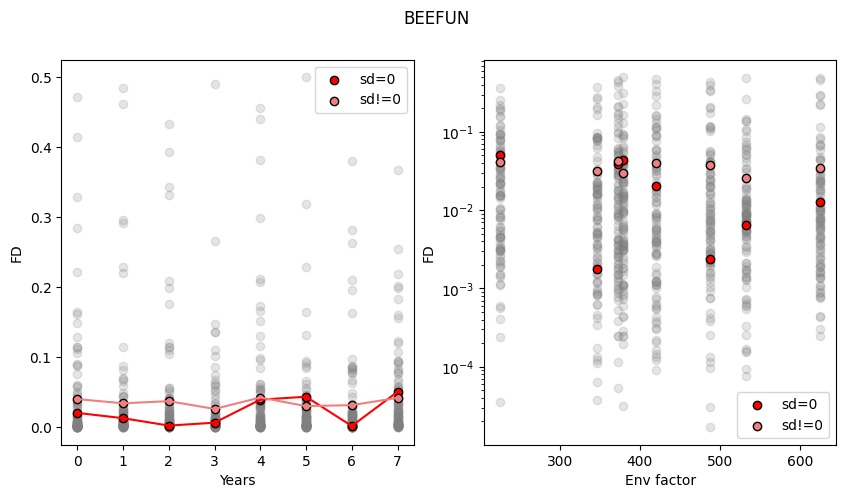

In [295]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
for i in OmegaS_BEEFUN:
    plt.scatter(range(len(i)),i,color='gray',alpha=0.2)
    
plt.plot(range(len(OmegaBEEFUN)), OmegaBEEFUN,color='red')
plt.scatter(range(len(OmegaBEEFUN)), OmegaBEEFUN,color='red',
            edgecolors='black',label='sd=0')

plt.plot(range(OmegaS_BEEFUN.shape[1]), np.mean(OmegaS_BEEFUN, axis=0), color='lightcoral')
plt.scatter(range(OmegaS_BEEFUN.shape[1]), np.mean(OmegaS_BEEFUN, axis=0), 
            color='lightcoral',edgecolors='black',label='sd!=0')

#plt.ylim(0.04,0.07)
plt.legend()
plt.xlabel('Years')
plt.ylabel('FD')
#plt.yscale('log')


plt.subplot(1,2,2)
for i in OmegaS_BEEFUN:
    plt.scatter(PBEEFUN,i,color='gray',alpha=0.2)
    
#plt.plot(PBEEFUN, OmegaBEEFUN,color='red')
plt.scatter(PBEEFUN, OmegaBEEFUN,color='red',
            edgecolors='black',label='sd=0')

#plt.plot(PBEEFUN, np.mean(OmegaS_BEEFUN, axis=0), color='lightcoral')
plt.scatter(PBEEFUN, np.mean(OmegaS_BEEFUN, axis=0), color='lightcoral',
            edgecolors='black',label='sd!=0')

#plt.ylim(0.04,0.065)
plt.legend()
plt.xlabel('Env factor')
plt.ylabel('FD')
plt.yscale('log')


plt.suptitle('BEEFUN')
plt.show()

In [263]:
dfOmegas_S_BEEFUN = pd.DataFrame()
for replica in range(OmegaS_BEEFUN.shape[0]):
    dfOmegas_S_BEEFUN[str(replica)] = OmegaS_BEEFUN[replica,:]
dfOmegas_S_BEEFUN['env'] = PBEEFUN

dfOmegas_S_BEEFUN = pd.melt(dfOmegas_S_BEEFUN, id_vars='env', var_name='replica', value_name='value')
dfOmegas_S_BEEFUN['replica'] = dfOmegas_S_BEEFUN['replica'].astype(int)
dfOmegas_S_BEEFUN

/var/folders/pn/ln92hbl56jj2m2mzfrm1cl4c0000gn/T/ipykernel_25100/3088424707.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dfOmegas_S_BEEFUN['env'] = PBEEFUN


,env,replica,value
0,420.6,0,0.000207
1,625.5,0,0.001634
2,487.9,0,0.002912
3,533.2,0,0.073887
4,372.4,0,0.014873
...,...,...,...
795,533.2,99,0.004431
796,372.4,99,0.004136
797,379.1,99,0.016042
798,346.7,99,0.011904


In [264]:
dfOmegas_S_BEEFUN.to_csv('erroprop_BEEFUN.csv')

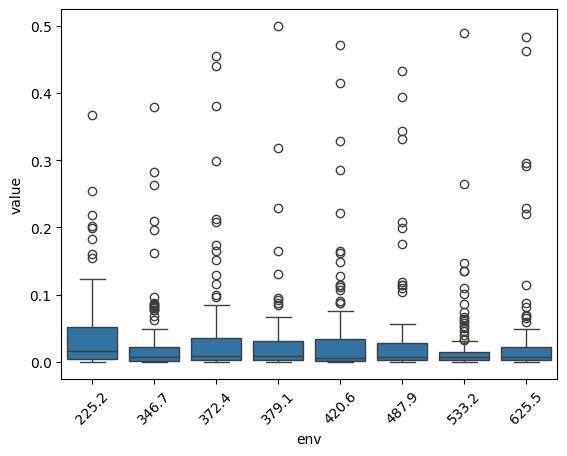

In [265]:
sns.boxplot(data=dfOmegas_S_BEEFUN, x='env', y='value')
plt.xticks(rotation=45)
plt.show()

In [266]:
dfOmegas_S_BEEFUN['env'].unique()

array([420.6, 625.5, 487.9, 533.2, 372.4, 379.1, 346.7, 225.2])

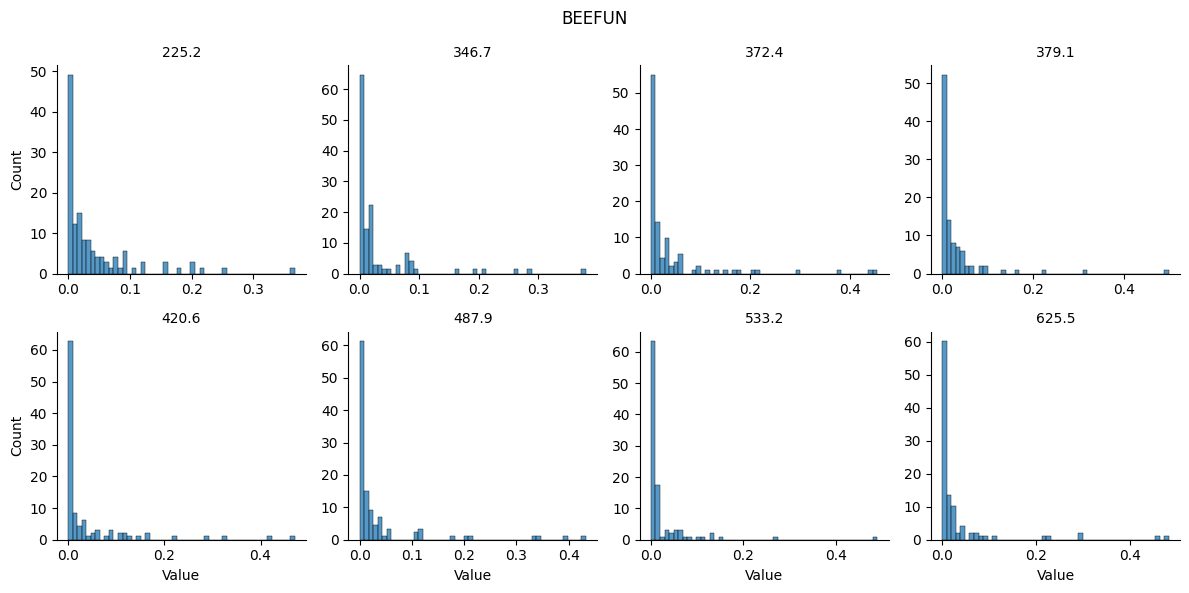

In [267]:
# Crear FacetGrid por env
g = sns.FacetGrid(dfOmegas_S_BEEFUN, col="env", col_wrap=4, sharex=False, sharey=False)

# Dibujar un histograma por cada subplot
g.map(sns.histplot, "value", bins=50, stat="density",kde=False)

# Ajustar diseño
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Value", "Count")

plt.suptitle('BEEFUN')
plt.tight_layout()
plt.show()

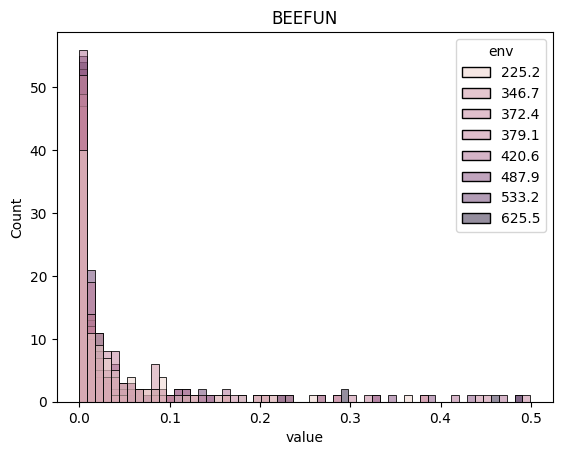

In [268]:
sns.histplot(data=dfOmegas_S_BEEFUN, x='value', hue='env')
plt.title('BEEFUN')
plt.show()

In [269]:
OmegaCARACOLES = calculateOmegas(calculateC('CARACOLES'))
OmegaS_CARACOLES = []
for i in range(100):
    OmegaS_CARACOLES.append(calculateOmegas(calculateC_sd('CARACOLES')))
    if i % 10 == 0:
        print(i)
OmegaS_CARACOLES = np.array(OmegaS_CARACOLES)
OmegaS_CARACOLES

0
10
20
30
40
50
60
70
80
90


array([[3.000000e-07, 2.102100e-03, 1.515300e-03, 2.023000e-04,
        3.258900e-03, 1.737000e-04, 1.015900e-03, 2.648526e-01,
        1.890178e-01],
       [1.050000e-04, 4.628000e-04, 3.060000e-05, 1.789000e-04,
        1.953100e-03, 2.796440e-02, 4.741000e-04, 1.508250e-02,
        7.317330e-02],
       [8.579000e-04, 3.814000e-04, 7.600000e-06, 1.440000e-05,
        9.665000e-04, 1.304100e-03, 1.914400e-03, 1.162183e-01,
        1.137680e-02],
       [1.294500e-03, 1.487000e-03, 2.080000e-05, 2.640500e-03,
        2.047000e-04, 8.052600e-03, 2.264190e-02, 5.665300e-03,
        7.944070e-02],
       [1.526600e-03, 3.700000e-05, 5.449000e-04, 1.607000e-04,
        3.006580e-02, 2.173000e-04, 3.924200e-03, 7.576900e-03,
        1.074510e-02],
       [2.296700e-03, 7.008700e-03, 8.900000e-06, 1.011800e-03,
        2.751200e-03, 3.295900e-03, 9.988000e-04, 4.964700e-03,
        4.072500e-03],
       [6.425000e-04, 1.058380e-02, 3.628000e-04, 8.220000e-05,
        2.995600e-03, 9.176000

In [270]:
PCARACOLES = giveP('CARACOLES')
PCARACOLES

array([420.6, 625.5, 487.9, 533.2, 372.4, 379.1, 346.7, 225.2, 285.2])

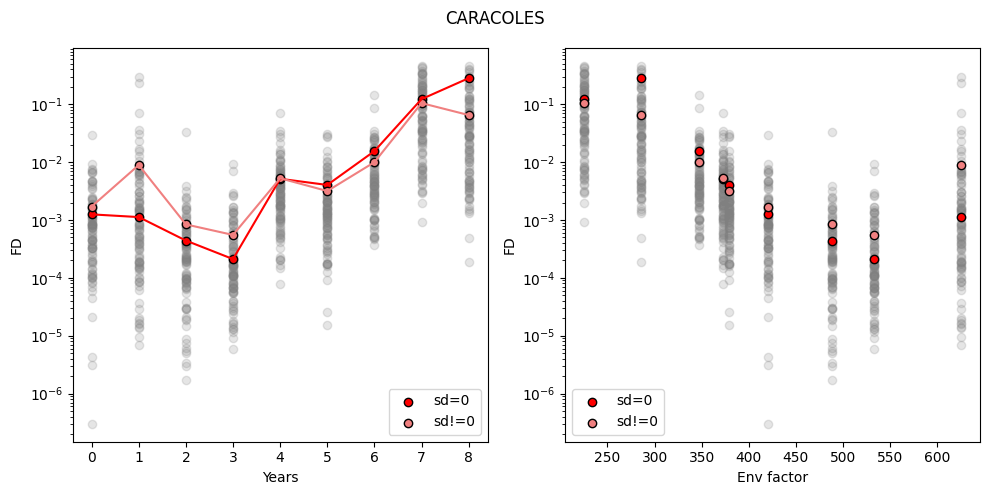

In [323]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
for i in OmegaS_CARACOLES:
    plt.scatter(range(len(i)),i,color='gray',alpha=0.2)
    
plt.plot(range(len(OmegaCARACOLES)), OmegaCARACOLES,color='red')
plt.scatter(range(len(OmegaCARACOLES)), OmegaCARACOLES,color='red',
            edgecolors='black',label='sd=0')

plt.plot(range(OmegaS_CARACOLES.shape[1]), np.mean(OmegaS_CARACOLES, axis=0), color='lightcoral')
plt.scatter(range(OmegaS_CARACOLES.shape[1]), np.mean(OmegaS_CARACOLES, axis=0), 
            color='lightcoral',edgecolors='black',label='sd!=0')

#plt.ylim(0.022,0.05)
plt.legend()
plt.xlabel('Years')
plt.ylabel('FD')
plt.yscale('log')


plt.subplot(1,2,2)
for i in OmegaS_CARACOLES:
    plt.scatter(PCARACOLES,i,color='gray',alpha=0.2)
    
#plt.plot(PCARACOLES, OmegaCARACOLES,color='red')
plt.scatter(PCARACOLES, OmegaCARACOLES,color='red',
            edgecolors='black',label='sd=0')

#plt.plot(PCARACOLES, np.mean(OmegaS_CARACOLES, axis=0), color='lightcoral')
plt.scatter(PCARACOLES, np.mean(OmegaS_CARACOLES, axis=0), color='lightcoral',
            edgecolors='black',label='sd!=0')

#plt.ylim(0.0,0.065)
plt.legend()
plt.xlabel('Env factor')
plt.ylabel('FD')
plt.yscale('log')

plt.suptitle('CARACOLES')
plt.tight_layout()
plt.show()

In [326]:
dfexplain = pd.DataFrame({
    'P': PCARACOLES,
    'Omega': OmegaCARACOLES,
    'Years':range(len(PCARACOLES)),
})
dfexplain

,P,Omega,Years
0,420.6,0.001248,0
1,625.5,0.001120,1
2,487.9,0.000440,2
3,533.2,0.000211,3
4,372.4,0.005139,4
5,379.1,0.004019,5
6,346.7,0.015431,6
7,225.2,0.122173,7
8,285.2,0.281149,8


In [325]:
OmegaCARACOLES

array([1.247500e-03, 1.120100e-03, 4.397000e-04, 2.106000e-04,
       5.139100e-03, 4.018600e-03, 1.543120e-02, 1.221725e-01,
       2.811493e-01])

# Simon

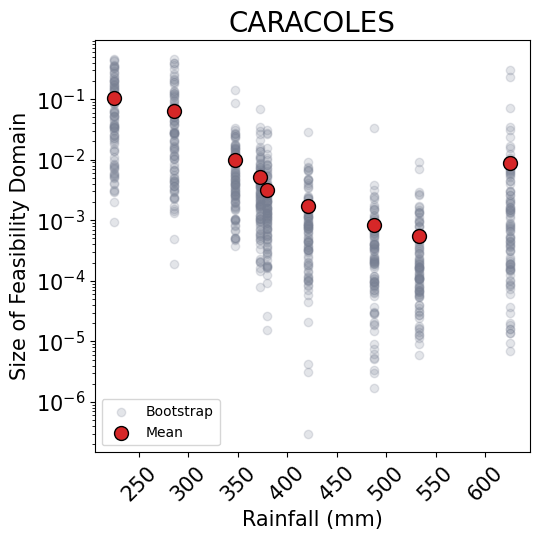

In [322]:
plt.figure(figsize=(5.5,5.5))

for i in OmegaS_CARACOLES:
    plt.scatter(PCARACOLES,i,color='#777F92',alpha=0.2,label='Bootstrap')


#plt.plot(PCARACOLES, np.mean(OmegaS_CARACOLES, axis=0), color='lightcoral')
plt.scatter(PCARACOLES, np.mean(OmegaS_CARACOLES, axis=0), color='#D62728',
            edgecolors='black',label='Mean',s=100)

#plt.ylim(0.0,0.065)


handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))  # Crea un diccionario para eliminar duplicados
plt.legend(unique_labels.values(), unique_labels.keys(), fontsize=10)

plt.xlabel('Rainfall (mm)',fontsize=15)
plt.ylabel('Size of Feasibility Domain',fontsize=15)
plt.yscale('log')
plt.xticks(fontsize=15,rotation=45)
plt.yticks(fontsize=15)

plt.title('CARACOLES',fontsize=20)
plt.tight_layout()
plt.show()

In [ ]:
dfOmegas_S_CARACOLES = pd.DataFrame()
for replica in range(OmegaS_CARACOLES.shape[0]):
    dfOmegas_S_CARACOLES[str(replica)] = OmegaS_CARACOLES[replica,:]
dfOmegas_S_CARACOLES['env'] = PCARACOLES

dfOmegas_S_CARACOLES = pd.melt(dfOmegas_S_CARACOLES, id_vars='env', var_name='replica', value_name='value')
dfOmegas_S_CARACOLES['replica'] = dfOmegas_S_CARACOLES['replica'].astype(int)
dfOmegas_S_CARACOLES

In [ ]:
dfOmegas_S_CARACOLES.to_csv('erroprop_CARACOLES.csv')

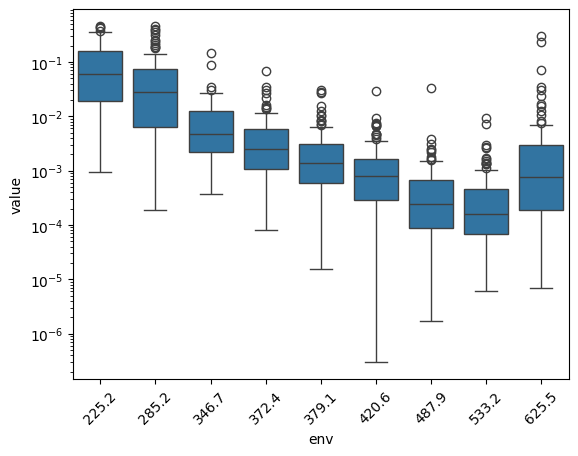

In [274]:
sns.boxplot(data=dfOmegas_S_CARACOLES, x='env', y='value')
plt.xticks(rotation=45)
plt.yscale('log')
plt.show()

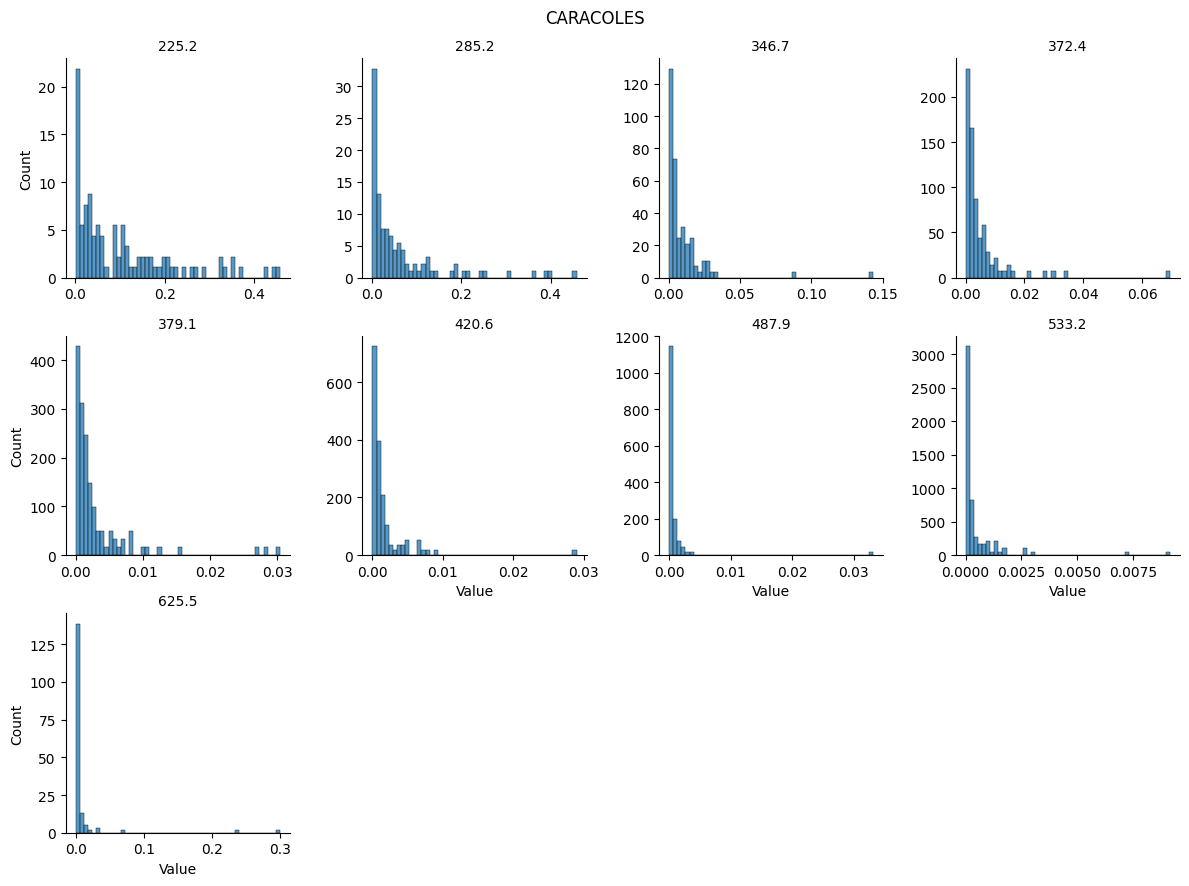

In [275]:
# Crear FacetGrid por env
g = sns.FacetGrid(dfOmegas_S_CARACOLES, col="env", col_wrap=4, sharex=False, sharey=False)

# Dibujar un histograma por cada subplot
g.map(sns.histplot, "value", bins=50, stat="density",kde=False)

# Ajustar diseño
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Value", "Count")

plt.suptitle('CARACOLES')

plt.tight_layout()
plt.show()

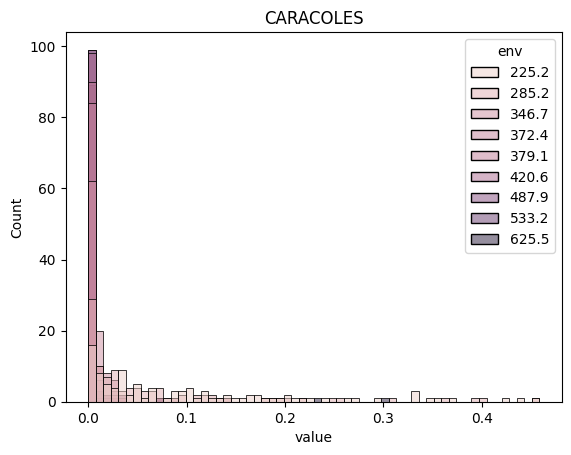

In [276]:
sns.histplot(data=dfOmegas_S_CARACOLES, x='value', hue='env')
plt.title('CARACOLES')
plt.show()

# DIG_13

In [277]:
OmegaDIG_13 = calculateOmegas(calculateC('DIG_13'))
OmegaS_DIG_13 = []
for i in range(100):
    OmegaS_DIG_13.append(calculateOmegas(calculateC_sd('DIG_13')))
    if i % 10 == 0:
        print(i)
OmegaS_DIG_13 = np.array(OmegaS_DIG_13)
OmegaS_DIG_13

0
10
20
30
40
50
60
70
80
90


array([[0.4786899, 0.4344695, 0.4283143, ..., 0.3809144, 0.4678103,
        0.4468699],
       [0.4880815, 0.4082787, 0.4345018, ..., 0.4221654, 0.4793043,
        0.4091007],
       [0.4824157, 0.3990463, 0.4897501, ..., 0.474757 , 0.4963799,
        0.4508377],
       ...,
       [0.47303  , 0.4031936, 0.4880043, ..., 0.4267711, 0.4726128,
        0.4875868],
       [0.4230959, 0.4743291, 0.4676501, ..., 0.4167925, 0.4127004,
        0.4436614],
       [0.4690808, 0.4586571, 0.4342849, ..., 0.4803838, 0.4651585,
        0.4959157]], shape=(100, 43))

In [278]:
PDIG_13 = giveP('DIG_13')
PDIG_13

array([0.24, 0.2 , 0.27, 0.13, 0.28, 0.28, 0.37, 0.19, 0.31, 0.21, 0.42,
       0.17, 0.18, 0.23, 0.21, 0.37, 0.26, 0.03, 0.01, 0.12, 0.48, 0.16,
       0.21, 0.4 , 0.38, 0.29, 0.29, 0.37, 0.43, 0.47, 0.39, 0.74, 0.11,
       0.27, 0.36, 0.27, 0.28, 0.19, 0.3 , 0.29, 0.23, 0.3 , 0.28])

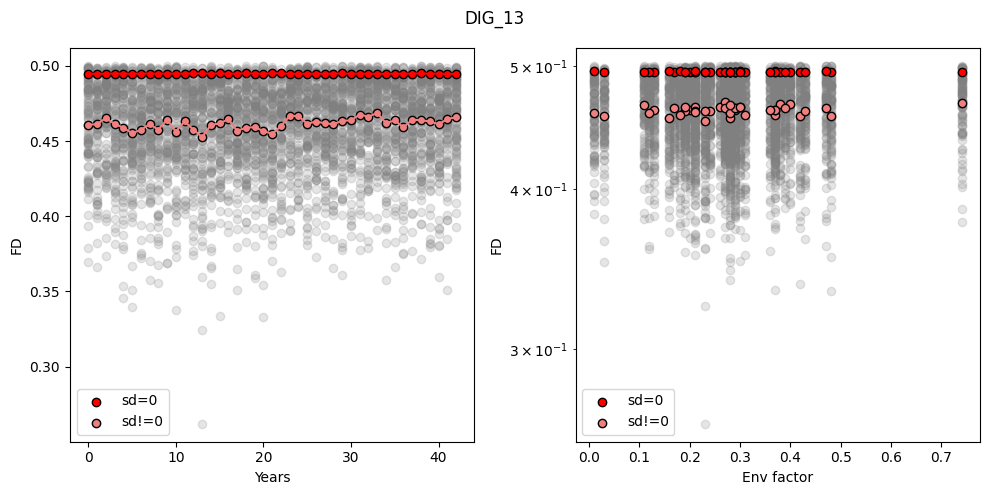

In [279]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
for i in OmegaS_DIG_13:
    plt.scatter(range(len(i)),i,color='gray',alpha=0.2)
    
plt.plot(range(len(OmegaDIG_13)), OmegaDIG_13,color='red')
plt.scatter(range(len(OmegaDIG_13)), OmegaDIG_13,color='red',
            edgecolors='black',label='sd=0')

plt.plot(range(OmegaS_DIG_13.shape[1]), np.mean(OmegaS_DIG_13, axis=0), color='lightcoral')
plt.scatter(range(OmegaS_DIG_13.shape[1]), np.mean(OmegaS_DIG_13, axis=0), 
            color='lightcoral',edgecolors='black',label='sd!=0')

#plt.ylim(0.022,0.05)
plt.legend()
plt.xlabel('Years')
plt.ylabel('FD')


plt.subplot(1,2,2)
for i in OmegaS_DIG_13:
    plt.scatter(PDIG_13,i,color='gray',alpha=0.2)
    
#plt.plot(PCARACOLES, OmegaCARACOLES,color='red')
plt.scatter(PDIG_13, OmegaDIG_13,color='red',
            edgecolors='black',label='sd=0')

#plt.plot(PCARACOLES, np.mean(OmegaS_CARACOLES, axis=0), color='lightcoral')
plt.scatter(PDIG_13, np.mean(OmegaS_DIG_13, axis=0), color='lightcoral',
            edgecolors='black',label='sd!=0')

#plt.ylim(0.0,0.065)
plt.legend()
plt.xlabel('Env factor')
plt.ylabel('FD')
plt.yscale('log')

plt.suptitle('DIG_13')
plt.tight_layout()
plt.show()

In [280]:
dfOmegas_S_DIG_13 = pd.DataFrame()
for replica in range(OmegaS_DIG_13.shape[0]):
    dfOmegas_S_DIG_13[str(replica)] = OmegaS_DIG_13[replica,:]
dfOmegas_S_DIG_13['env'] = PDIG_13

dfOmegas_S_DIG_13 = pd.melt(dfOmegas_S_DIG_13, id_vars='env', var_name='replica', value_name='value')
dfOmegas_S_DIG_13['replica'] = dfOmegas_S_DIG_13['replica'].astype(int)
dfOmegas_S_DIG_13 

/var/folders/pn/ln92hbl56jj2m2mzfrm1cl4c0000gn/T/ipykernel_25100/2361881708.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dfOmegas_S_DIG_13['env'] = PDIG_13


,env,replica,value
0,0.24,0,0.478690
1,0.20,0,0.434470
2,0.27,0,0.428314
3,0.13,0,0.478633
4,0.28,0,0.437524
...,...,...,...
4295,0.30,99,0.467174
4296,0.29,99,0.491582
4297,0.23,99,0.480384
4298,0.30,99,0.465159


In [281]:
dfOmegas_S_DIG_13.to_csv('erroprop_DIG_13.csv')

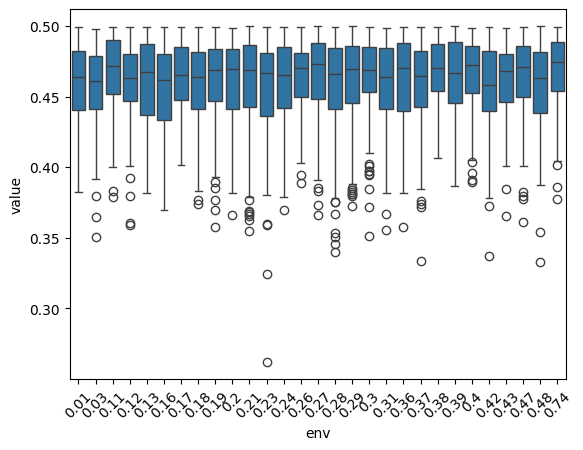

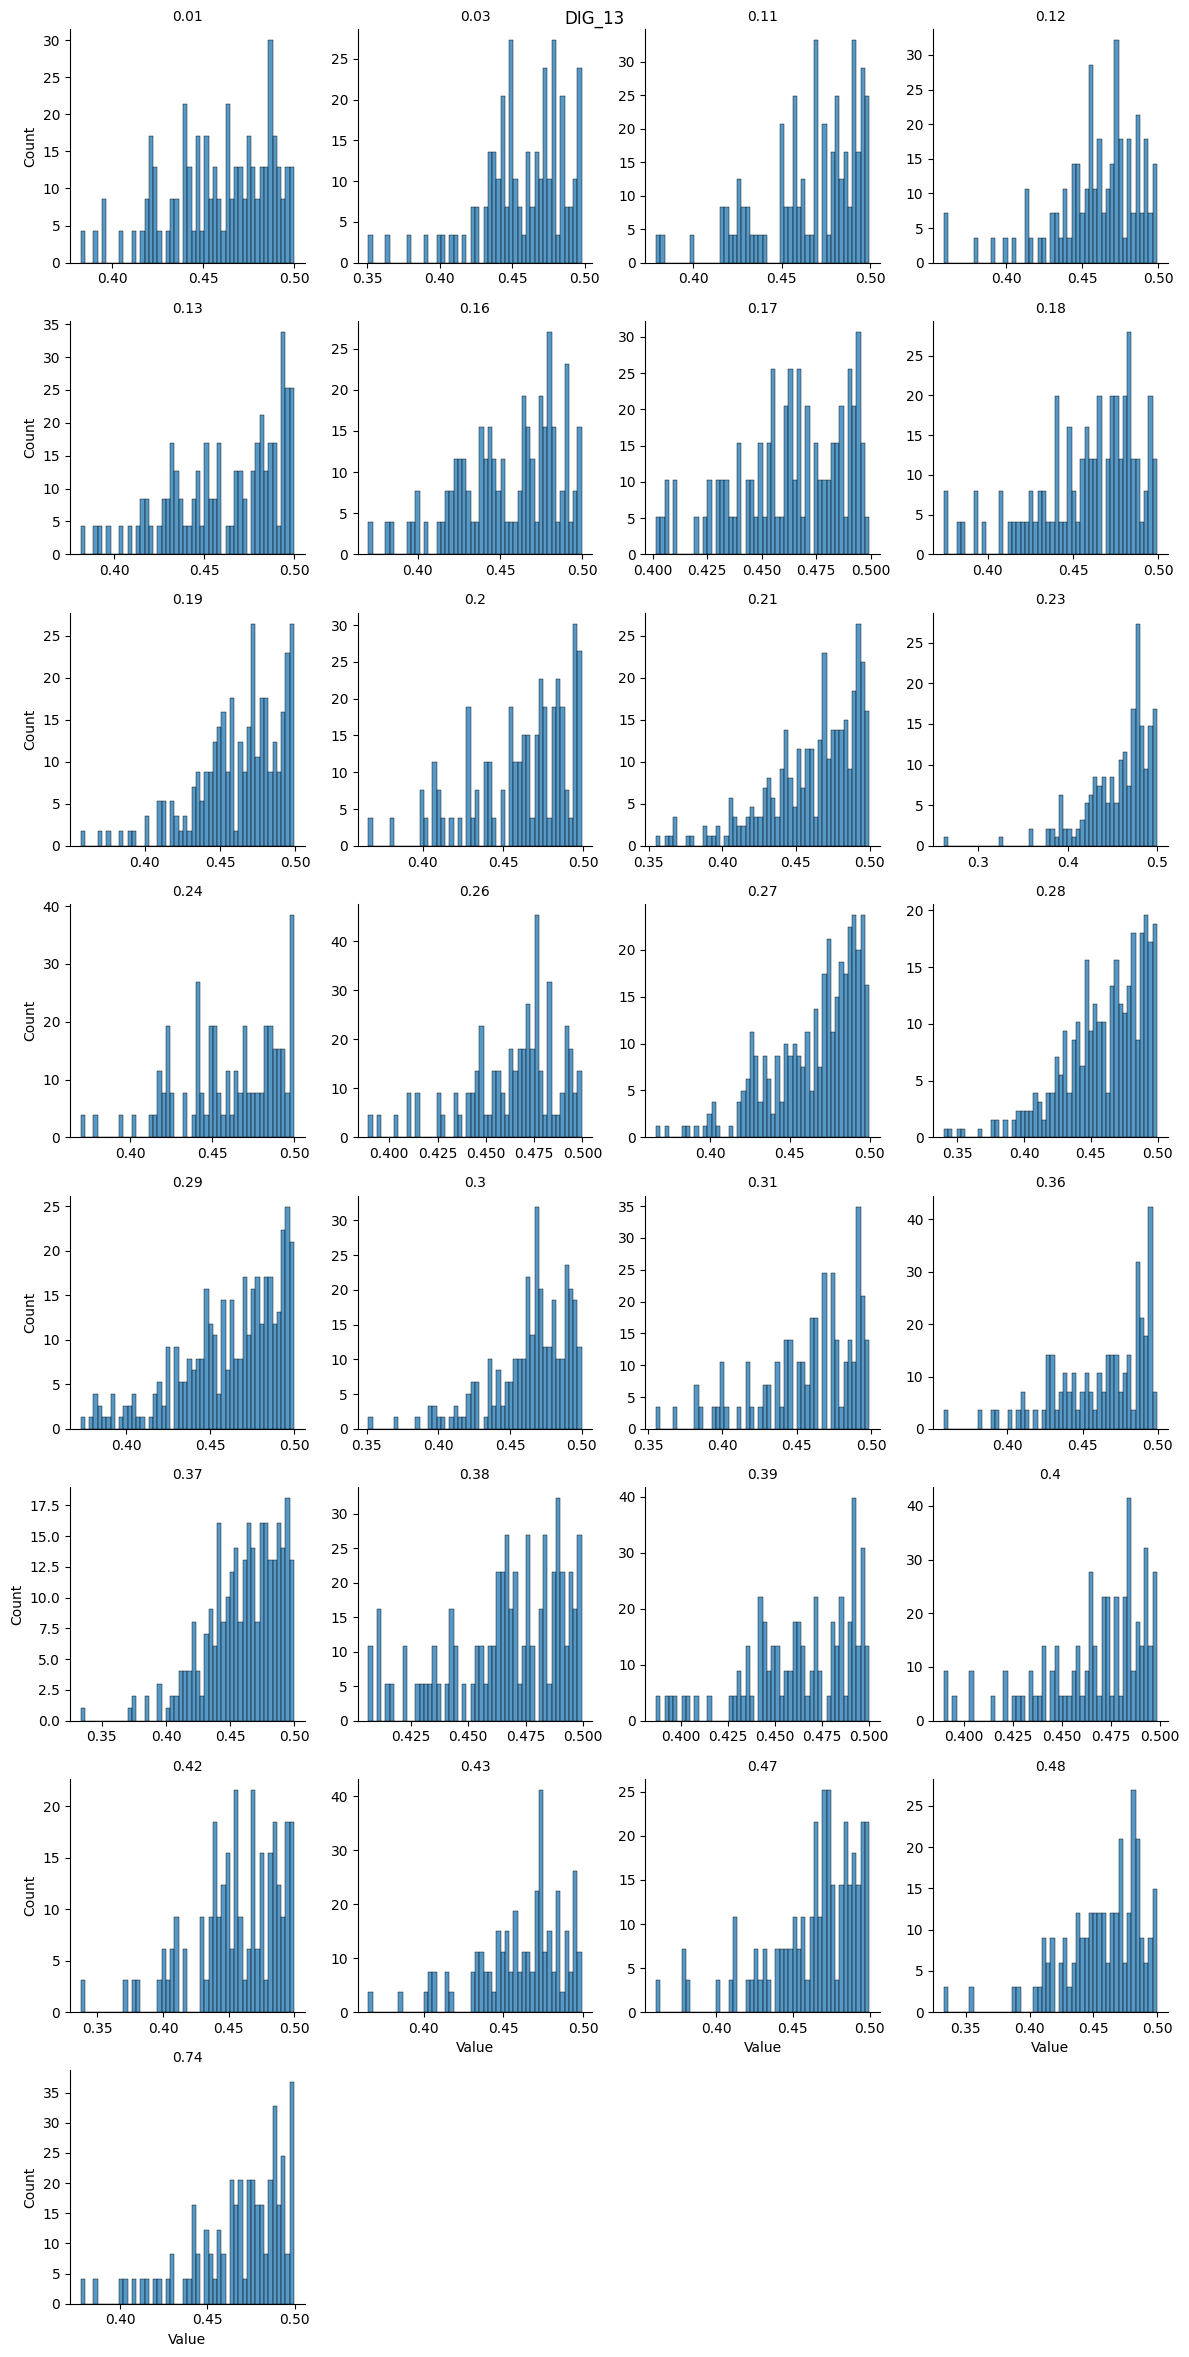

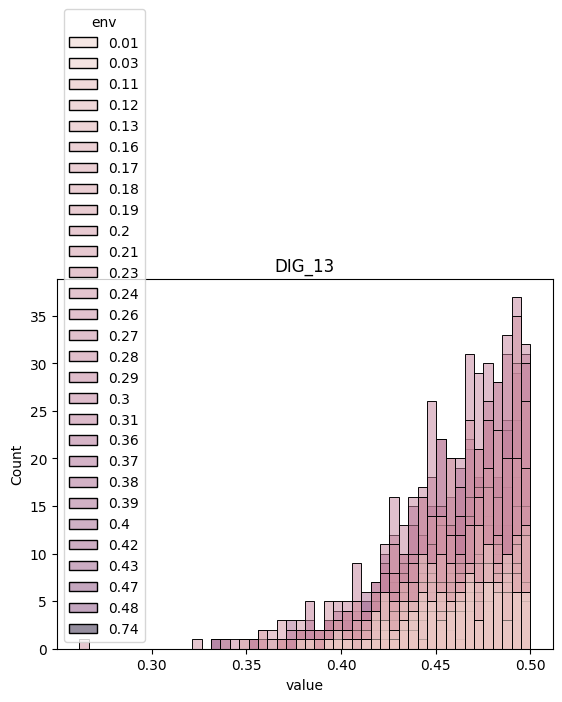

In [282]:
sns.boxplot(data=dfOmegas_S_DIG_13, x='env', y='value')
plt.xticks(rotation=45)
plt.show()

# Crear FacetGrid por env
g = sns.FacetGrid(dfOmegas_S_DIG_13, col="env", col_wrap=4, sharex=False, sharey=False)

# Dibujar un histograma por cada subplot
g.map(sns.histplot, "value", bins=50, stat="density",kde=False)

# Ajustar diseño
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Value", "Count")

plt.suptitle('DIG_13')

plt.tight_layout()
plt.show()

sns.histplot(data=dfOmegas_S_DIG_13, x='value', hue='env')
plt.title('DIG_13')
plt.show()

# DIG_50

In [283]:
OmegaDIG_50 = calculateOmegas(calculateC('DIG_50'))
OmegaS_DIG_50 = []
for i in range(100):
    OmegaS_DIG_50.append(calculateOmegas(calculateC_sd('DIG_50')))
    if i % 10 == 0:
        print(i)
OmegaS_DIG_50 = np.array(OmegaS_DIG_50)
OmegaS_DIG_50

0
10
20
30
40
50
60
70
80
90


array([[0.4737669, 0.447668 , 0.469166 , ..., 0.0483423, 0.4984183,
        0.4274696],
       [0.4878524, 0.2314783, 0.4731894, ..., 0.3484089, 0.0941173,
        0.2184224],
       [0.4611468, 0.4760662, 0.4672046, ..., 0.3416901, 0.4997419,
        0.4072163],
       ...,
       [0.2924921, 0.1323542, 0.1079979, ..., 0.3279386, 0.2899335,
        0.1055345],
       [0.4923261, 0.4706237, 0.4459155, ..., 0.4947809, 0.0879994,
        0.478138 ],
       [0.3970857, 0.483612 , 0.4952973, ..., 0.1891757, 0.2711915,
        0.2578808]], shape=(100, 27))

In [284]:
PDIG_50 = giveP('DIG_50')
PDIG_50

array([3.7, 3.1, 3.8, 3.4, 2.7, 2. , 1.9, 2.8, 2.3, 2.8, 3.7, 3.2, 3. ,
       2.5, 2.7, 3. , 3.7, 3.9, 3.7, 3.9, 3.4, 3.1, 3.7, 2.8, 2.6, 2.7,
       3.3])

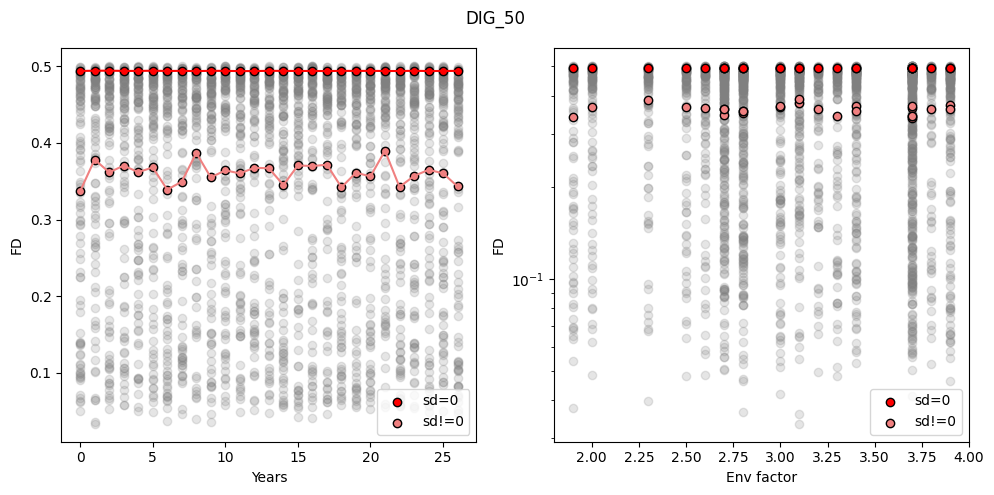

In [285]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
for i in OmegaS_DIG_50:
    plt.scatter(range(len(i)),i,color='gray',alpha=0.2)
    
plt.plot(range(len(OmegaDIG_50)), OmegaDIG_50,color='red')
plt.scatter(range(len(OmegaDIG_50)), OmegaDIG_50,color='red',
            edgecolors='black',label='sd=0')

plt.plot(range(OmegaS_DIG_50.shape[1]), np.mean(OmegaS_DIG_50, axis=0), color='lightcoral')
plt.scatter(range(OmegaS_DIG_50.shape[1]), np.mean(OmegaS_DIG_50, axis=0), 
            color='lightcoral',edgecolors='black',label='sd!=0')

#plt.ylim(0.022,0.05)
plt.legend()
plt.xlabel('Years')
plt.ylabel('FD')


plt.subplot(1,2,2)
for i in OmegaS_DIG_50:
    plt.scatter(PDIG_50,i,color='gray',alpha=0.2)
    
#plt.plot(PCARACOLES, OmegaCARACOLES,color='red')
plt.scatter(PDIG_50, OmegaDIG_50,color='red',
            edgecolors='black',label='sd=0')

#plt.plot(PCARACOLES, np.mean(OmegaS_CARACOLES, axis=0), color='lightcoral')
plt.scatter(PDIG_50, np.mean(OmegaS_DIG_50, axis=0), color='lightcoral',
            edgecolors='black',label='sd!=0')

#plt.ylim(0.0,0.065)
plt.legend()
plt.xlabel('Env factor')
plt.ylabel('FD')
plt.yscale('log')

plt.suptitle('DIG_50')
plt.tight_layout()
plt.show()

In [286]:
dfOmegas_S_DIG_50 = pd.DataFrame()
for replica in range(OmegaS_DIG_50.shape[0]):
    dfOmegas_S_DIG_50[str(replica)] = OmegaS_DIG_50[replica,:]
dfOmegas_S_DIG_50['env'] = PDIG_50

dfOmegas_S_DIG_50 = pd.melt(dfOmegas_S_DIG_50, id_vars='env', var_name='replica', value_name='value')
dfOmegas_S_DIG_50['replica'] = dfOmegas_S_DIG_50['replica'].astype(int)
dfOmegas_S_DIG_50 

/var/folders/pn/ln92hbl56jj2m2mzfrm1cl4c0000gn/T/ipykernel_25100/3685321016.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dfOmegas_S_DIG_50['env'] = PDIG_50


,env,replica,value
0,3.7,0,0.473767
1,3.1,0,0.447668
2,3.8,0,0.469166
3,3.4,0,0.494077
4,2.7,0,0.494672
...,...,...,...
2695,3.7,99,0.307501
2696,2.8,99,0.137642
2697,2.6,99,0.189176
2698,2.7,99,0.271192


In [287]:
dfOmegas_S_DIG_50.to_csv('erroprop_DIG_50.csv')

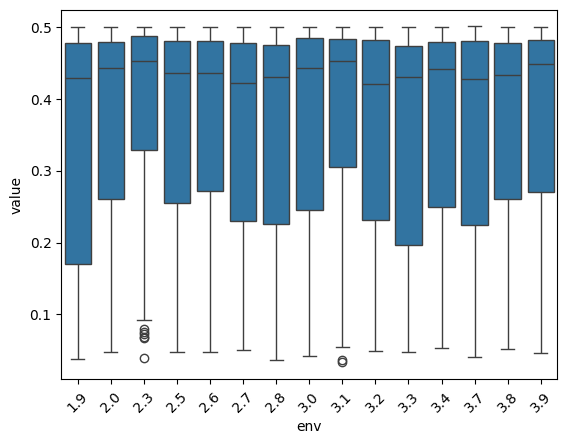

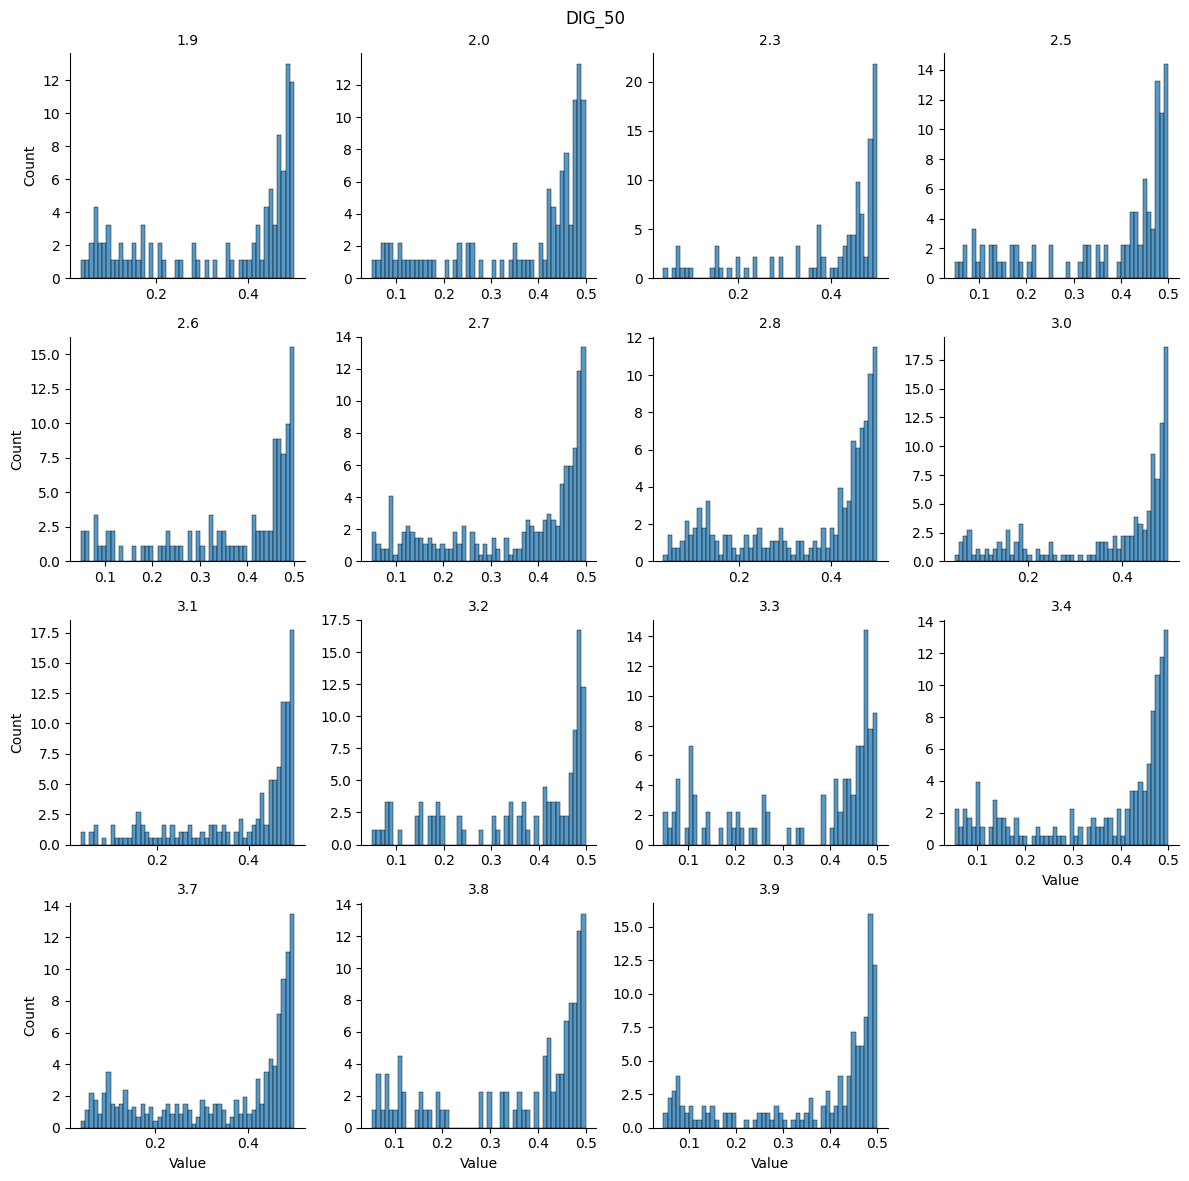

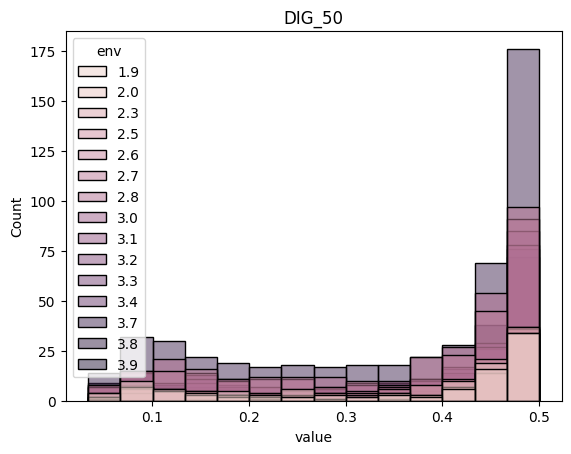

In [288]:
sns.boxplot(data=dfOmegas_S_DIG_50, x='env', y='value')
plt.xticks(rotation=45)
plt.show()

# Crear FacetGrid por env
g = sns.FacetGrid(dfOmegas_S_DIG_50, col="env", col_wrap=4, sharex=False, sharey=False)

# Dibujar un histograma por cada subplot
g.map(sns.histplot, "value", bins=50, stat="density",kde=False)

# Ajustar diseño
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Value", "Count")

plt.suptitle('DIG_50')

plt.tight_layout()
plt.show()

sns.histplot(data=dfOmegas_S_DIG_50, x='value', hue='env')
plt.title('DIG_50')
plt.show()

# LPI_2858

In [289]:
OmegaLPI_2858 = calculateOmegas(calculateC('LPI_2858'))
OmegaS_LPI_2858 = []
for i in range(100):
    OmegaS_LPI_2858.append(calculateOmegas(calculateC_sd('LPI_2858')))
    if i % 10 == 0:
        print(i)
OmegaS_LPI_2858 = np.array(OmegaS_LPI_2858)
OmegaS_LPI_2858

0
10
20
30
40
50
60
70
80
90


array([[0.0410071, 0.018546 , 0.4571314, ..., 0.0081763, 0.3701522,
        0.1093865],
       [0.0246101, 0.268426 , 0.0107756, ..., 0.1926828, 0.0722414,
        0.0272283],
       [0.1969571, 0.0967105, 0.365405 , ..., 0.4263097, 0.4681527,
        0.0067668],
       ...,
       [0.1935925, 0.0313027, 0.0320129, ..., 0.0062318, 0.107965 ,
        0.2270963],
       [0.0466778, 0.0162844, 0.244399 , ..., 0.2989778, 0.4624332,
        0.0402361],
       [0.0478656, 0.4343758, 0.0046931, ..., 0.3535795, 0.1656418,
        0.0880009]], shape=(100, 15))

In [290]:
PLPI_2858 = giveP('LPI_2858')
PLPI_2858

array([119, 311, 272, 225, 214, 156, 252, 153, 132, 145, 337, 107, 119,
       187, 204])

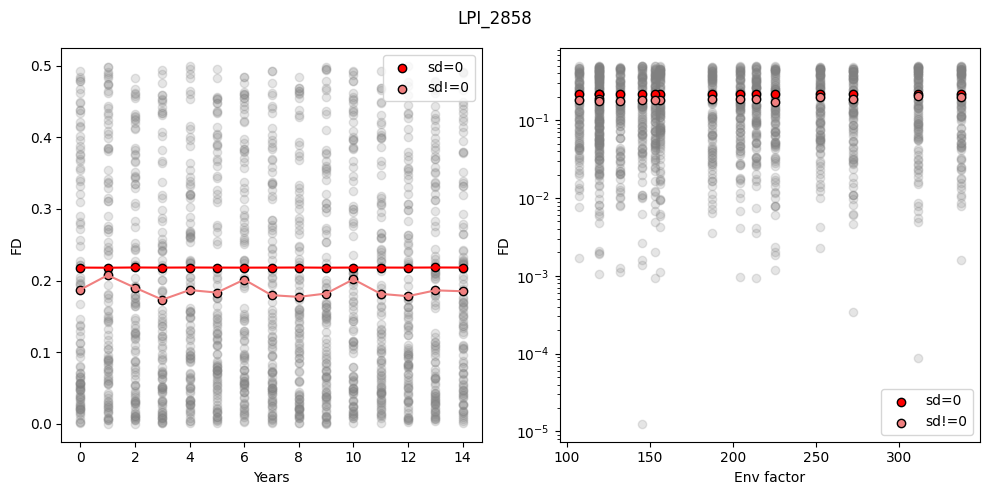

In [291]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
for i in OmegaS_LPI_2858:
    plt.scatter(range(len(i)),i,color='gray',alpha=0.2)
    
plt.plot(range(len(OmegaLPI_2858)), OmegaLPI_2858,color='red')
plt.scatter(range(len(OmegaLPI_2858)), OmegaLPI_2858,color='red',
            edgecolors='black',label='sd=0')

plt.plot(range(OmegaS_LPI_2858.shape[1]), np.mean(OmegaS_LPI_2858, axis=0), color='lightcoral')
plt.scatter(range(OmegaS_LPI_2858.shape[1]), np.mean(OmegaS_LPI_2858, axis=0), 
            color='lightcoral',edgecolors='black',label='sd!=0')

#plt.ylim(0.022,0.05)
plt.legend()
plt.xlabel('Years')
plt.ylabel('FD')


plt.subplot(1,2,2)
for i in OmegaS_LPI_2858:
    plt.scatter(PLPI_2858,i,color='gray',alpha=0.2)
    
#plt.plot(PCARACOLES, OmegaCARACOLES,color='red')
plt.scatter(PLPI_2858, OmegaLPI_2858,color='red',
            edgecolors='black',label='sd=0')

#plt.plot(PCARACOLES, np.mean(OmegaS_CARACOLES, axis=0), color='lightcoral')
plt.scatter(PLPI_2858, np.mean(OmegaS_LPI_2858, axis=0), color='lightcoral',
            edgecolors='black',label='sd!=0')

#plt.ylim(0.0,0.065)
plt.legend()
plt.xlabel('Env factor')
plt.ylabel('FD')
plt.yscale('log')

plt.suptitle('LPI_2858')
plt.tight_layout()
plt.show()

In [292]:
dfOmegas_S_LPI_2858 = pd.DataFrame()
for replica in range(OmegaS_LPI_2858.shape[0]):
    dfOmegas_S_LPI_2858[str(replica)] = OmegaS_LPI_2858[replica,:]
dfOmegas_S_LPI_2858['env'] = PLPI_2858

dfOmegas_S_LPI_2858 = pd.melt(dfOmegas_S_LPI_2858, id_vars='env', var_name='replica', value_name='value')
dfOmegas_S_LPI_2858['replica'] = dfOmegas_S_LPI_2858['replica'].astype(int)
dfOmegas_S_LPI_2858

/var/folders/pn/ln92hbl56jj2m2mzfrm1cl4c0000gn/T/ipykernel_25100/4276216935.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dfOmegas_S_LPI_2858['env'] = PLPI_2858


,env,replica,value
0,119,0,0.041007
1,311,0,0.018546
2,272,0,0.457131
3,225,0,0.319004
4,214,0,0.265010
...,...,...,...
1495,337,99,0.282794
1496,107,99,0.071711
1497,119,99,0.353580
1498,187,99,0.165642


In [293]:
dfOmegas_S_LPI_2858.to_csv('erroprop_LPI_2858.csv')

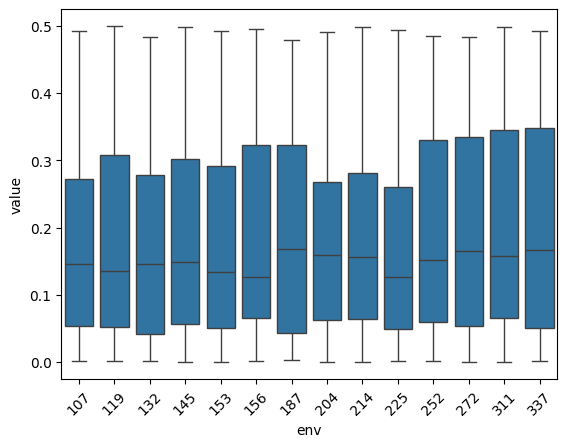

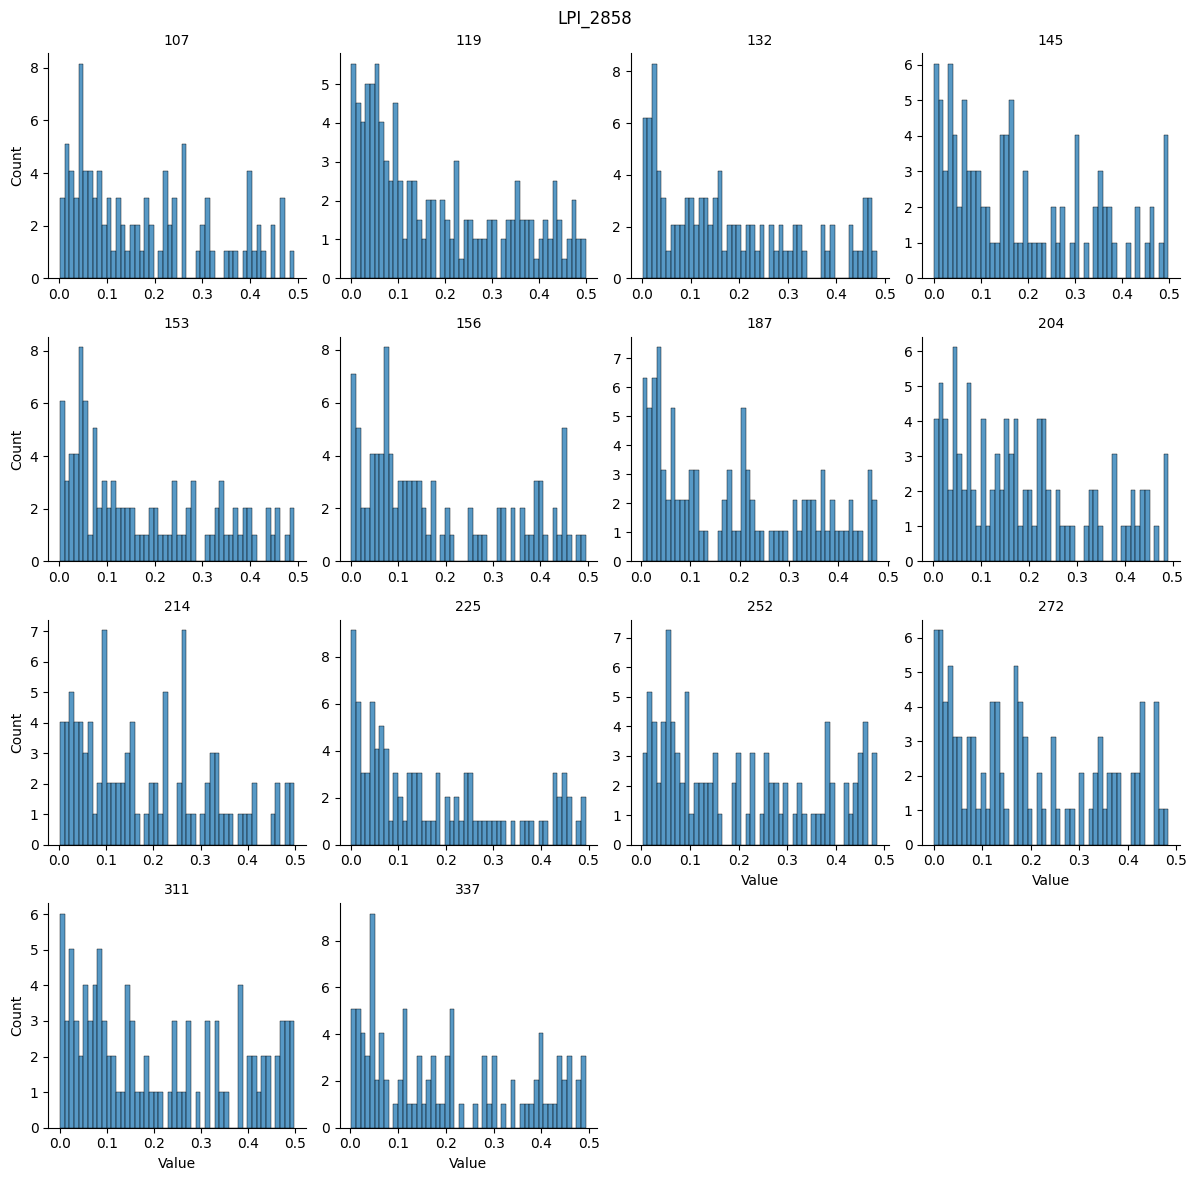

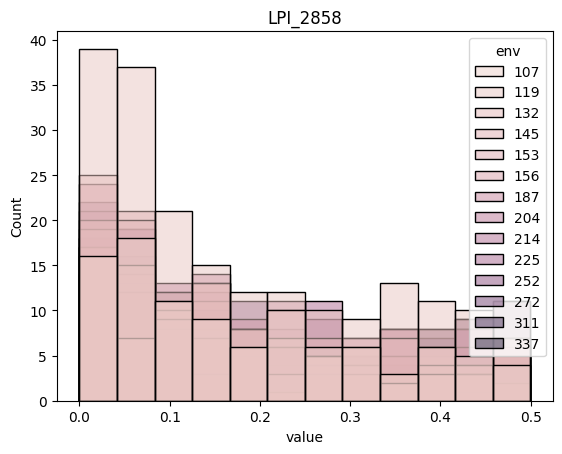

In [294]:
sns.boxplot(data=dfOmegas_S_LPI_2858, x='env', y='value')
plt.xticks(rotation=45)
plt.show()

# Crear FacetGrid por env
g = sns.FacetGrid(dfOmegas_S_LPI_2858, col="env", col_wrap=4, sharex=False, sharey=False)

# Dibujar un histograma por cada subplot
g.map(sns.histplot, "value", bins=50, stat="density",kde=False)

# Ajustar diseño
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Value", "Count")

plt.suptitle('LPI_2858')

plt.tight_layout()
plt.show()

sns.histplot(data=dfOmegas_S_LPI_2858, x='value', hue='env')
plt.title('LPI_2858')
plt.show()